This notebook handles:

1. Loading the processed complaints dataset.
2. Applying vectorization techniques (TF-IDF and Count Vectorization) to the processed text column
3. Inspecting vectorized data (e.g., vocabulary size, sample features)
4. Saving vectorized matrices for use in topic modeling (as sparse matrices via joblib for efficiency)
5. Basic visualization of term frequencies

We use scikit-learn for vectorization, as outlined in the conception phase. TF-IDF will highlight significant terms (good for NMF), while Count Vectorization retains raw frequencies (better for LDA).

## 1. Import Libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.sparse import save_npz, load_npz  

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# If needed, import custom helpers from utils
# from ../utils/helpers import some_custom_function  # Uncomment if you have helpers.py with utilities

## 2. Load Processed data

In [ ]:
# Load the processed dataset
df = pd.read_csv('../data/processed/processed_complaints.csv')
df.shape

(242348, 11)

In [6]:
# Ensure 'processed_text' column exists and handle any NaNs
df['processed_text'] = df['processed_text'].fillna('')  # Replace NaNs with empty strings
texts = df['processed_text'].tolist()
print(f"Number of documents: {len(texts)}")

Number of documents: 242348


## 3. Vectorization

Two vectorized representations are created:

1. TF-IDF Vectorization: Weights terms by importance (inverse document frequency).
2. Count Vectorization: Simple term frequency counts.

Hyperparameters (tunable based on conception phase risks like poor coherence):

- min_df=5: Ignore terms in fewer than 5 documents (reduce noise).
- max_df=0.95: Ignore terms in more than 95% of documents (remove overly common terms).
- ngram_range=(1,2): Include unigrams and bigrams for better context.

### a) TF-IDF Vectorization

In [9]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    max_features=10000  # Limit vocabulary size for memory efficiency
)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Inspect
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Vocabulary Size: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Sample Features: {tfidf_vectorizer.get_feature_names_out()[:10]}")

# Save the vectorizer and matrix
joblib.dump(tfidf_vectorizer, '../data/processed/tfidf_vectorizer.pkl')
save_npz('../data/processed/tfidf_matrix.npz', tfidf_matrix)

TF-IDF Matrix Shape: (242348, 1617)
Vocabulary Size: 1617
Sample Features: ['abandon' 'abandon bike' 'access' 'accessory' 'accessory store'
 'accident' 'activity' 'address' 'adjacent' 'adjacent protect']


### b) Count Vectorization

In [10]:
# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    max_features=10000  # Same limit for consistency
)

# Fit and transform
count_matrix = count_vectorizer.fit_transform(texts)

# Inspect
print(f"Count Matrix Shape: {count_matrix.shape}")
print(f"Vocabulary Size: {len(count_vectorizer.get_feature_names_out())}")
print(f"Sample Features: {count_vectorizer.get_feature_names_out()[:10]}")

# Save the vectorizer and matrix
joblib.dump(count_vectorizer, '../data/processed/count_vectorizer.pkl')
save_npz('../data/processed/count_matrix.npz', count_matrix)

Count Matrix Shape: (242348, 1617)
Vocabulary Size: 1617
Sample Features: ['abandon' 'abandon bike' 'access' 'accessory' 'accessory store'
 'accident' 'activity' 'address' 'adjacent' 'adjacent protect']


## 4. Inspection and Visualization

Term Frequency Distribution and (from Count Vectorizer) and Word Cloud for TF-IDF Weights

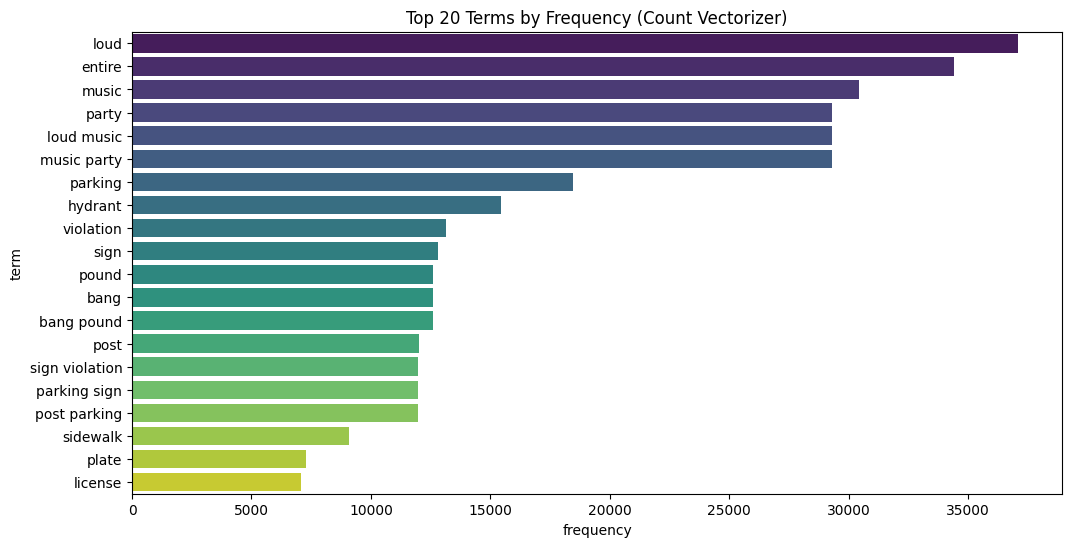

In [15]:
# Get term frequencies
term_freq = np.asarray(count_matrix.sum(axis=0)).flatten()
terms = count_vectorizer.get_feature_names_out()

# Create DataFrame for top terms
freq_df = pd.DataFrame({'term': terms, 'frequency': term_freq})
freq_df = freq_df.sort_values('frequency', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='term', data=freq_df, hue="term", palette='viridis')
plt.title('Top 20 Terms by Frequency (Count Vectorizer)')
plt.show()

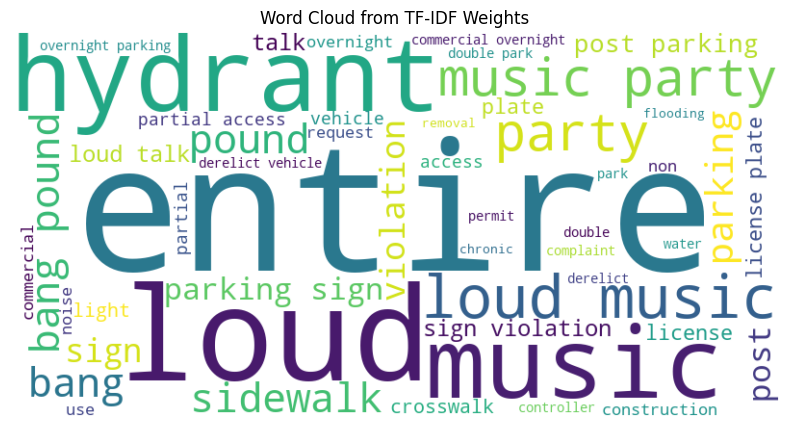

In [16]:
# Get TF-IDF weights (average across documents)
tfidf_weights = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_weights = dict(zip(terms, tfidf_weights))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate_from_frequencies(word_weights)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from TF-IDF Weights')
plt.show()